<center>
<img src="https://raw.githubusercontent.com/FUlyankin/ekenam_grand_research/master/images/cover.png">
</center>


# <center> Иканам гранд рисёрч </center>
## <center>  Часть седьмая: моделирование </center>


Проект **Иканам гранд рисёрч** реализуется [Иканам стьюдентс коммьюнити,](https://vk.com/ikanam)
в частности [вот этим парнем по имени Филипп.](https://vk.com/ppilif)  Если вы нашли ошибку или у вас есть предложения, замечания, деньги, слава или женщины, можно ему написать. Весь говнокод, использованный в исследовании распостраняется по лицензии [Creative Commons CC BY-NC-SA 4.0.](https://creativecommons.org/licenses/by-nc-sa/4.0/) Его можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу рисёрча.](https://github.com/FUlyankin/ekenam_grand_research) 


In [644]:
import warnings     # Игнорирование варнингов
warnings.filterwarnings("ignore")  

In [645]:
import numpy as np     # Нумпай для векторов 
import pandas as pd    # Пандас для табличек 
# Округлять в табличках значения до второго знака
pd.set_option('precision', 2)           

# Пакеты для графииков
import matplotlib
import matplotlib.pyplot as plt                             
import seaborn as sns
plt.style.use('ggplot')   # Правильный стиль графиков   

# Пакет для красивых циклов. При желании его можно отключить. Тогда из всех циклов придётся 
# удалять команду tqdm_notebook.
from tqdm import tqdm_notebook   # подробнее: https://github.com/tqdm/tqdm

In [646]:
%matplotlib inline  

Перейдём в папку с данными. Это новый финт. Так мы ешё не выпендривались. 

In [647]:
cd '../5. Data prepare'

/Users/fulyankin/Documents/ekanam_grand_research/5. Data prepare


# 1. Подгрузка данных и их дробление 

Все названия переменных я, конечно же копировал из прошлого файла. 

In [648]:
# Подгрузили файлик с описание переменных 
des_var = pd.read_csv('variables.csv', sep=',')
name = [ ]
for v in des_var['название ']:
    if v[-1] =="'":
        name.append(v[:-1])
    elif v[-2:] == "',":
        name.append(v[:-2])
    else:
        name.append(v)
des_var['название '] = name

# Создаём списки из переменных для картинок и скалирования 
real_set = set(des_var[des_var['тип переменной'] == 'real']['название '])
cnt_set= des_var[des_var['тип переменной'] == 'cnt']['название '].get_values()
cat_set = des_var[des_var['тип переменной'] == 'cat']['название '].get_values()
dummy_set = des_var[des_var['тип переменной'] == 'dummy']['название '].get_values()

# Откидываем переменные, к которым я отношусь скептически
print(des_var.shape)
des_var = des_var[des_var['моё отношение к переменной'] > -1]
print(des_var.shape)

des_var.head()

(196, 5)
(142, 5)


,название,краткое описание,тип переменной,источник,моё отношение к переменной
0,uids,id вконтакте,teh,profile,0
1,firstname,имя,teh,profile,0
2,lastname,фамилия,teh,profile,0
3,prohodnoy,проходной балл в год поступления,real,order,0
4,target_1,закончил ли 1 курс,dummy,target,0


In [649]:
des_var[des_var['тип переменной'] == 'teh']['название '].get_values()

array(['uids', 'firstname', 'lastname', 'profile_first_name',
       'profile_last_name', 'wall_repost_groups_id',
       'wall_repost_people_id', 'wall_repost_groups_id',
       'wall_repost_people_id'], dtype=object)

In [718]:
# Команды для преобразования категориальных переменных
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

# Подгрузили самые полные данные 
data = pd.read_csv('data4_prof_ph_wl.csv', sep='\t', index_col=False)

# Выбрасываем разные не очень важные куски. Здесь мы будем то комментировать, то снимать комментарии и прогонять 
# дальше всё время один и тот же код для разных подвыборок 
# выкинуть всех кто без id 
data.dropna(subset=['uids'],axis=0,inplace=True)

# 1.Технические переменные
data.drop(['uids', 'profile_first_name', 'profile_last_name', 'wall_repost_groups_id','wall_repost_people_id',
           'wall_repost_groups_id', 'wall_repost_people_id'] ,axis=1, inplace = True)

# 2.Переменные по приказам
data.drop(['prohodnoy', 'kurs', 'zima', 'leto', 'akadem', 'target_2', 'target_3', 'target_4'], axis=1, inplace = True)

# data.drop(['EGE', 'lgota', 'chelevoe', 'olimp', 'dogovor', 'ochko-zaochka', 'ege_diff', 'kozko'], axis=1, inplace = True)

# 3. Субъективные переменные 
# data.drop([ 'hodit_para','hodit_tusa'], axis=1, inplace = True)
data.hodit_tusa.fillna(data.hodit_tusa.mean(), inplace= True)     # Внимание! Это здесь временно! Разобраться 
data.hodit_para.fillna(data.hodit_para.mean(), inplace = True)    # РАЗОБРАТЬСЯ С ПРОПУСКАМИ!

# 4. Переменные, которые отвечают за профиль
# Дамми
# uslovie = (des_var['источник'] == 'profile')&(des_var['тип переменной'] == 'dummy')
# data.drop(des_var[uslovie]['название '].get_values() ,axis=1, inplace = True)

# Счётчики 
# uslovie = (des_var['источник'] == 'profile')&(des_var['тип переменной'] == 'cnt')
# data.drop(des_var[uslovie]['название '].get_values() ,axis=1, inplace = True)

# Категориальные
# Заполним все пропуски каким-нибудь символом для выделения отдельных дамми под них
#cat_vars = [var for var in data.columns if var in cat_set]
#X_cat = data[cat_vars].fillna('NA').applymap(str)
#my_encoder = DV(sparse = False)
#X_cat_oh = pd.DataFrame(my_encoder.fit_transform(X_cat.T.to_dict().values()))

uslovie = (des_var['источник'] == 'profile')&(des_var['тип переменной'] == 'cat')
data.drop(des_var[uslovie]['название '].get_values() ,axis=1, inplace = True)


# 5. Переменные, которые отвечают за фотки
# Cчётчики
data['photo_like_cnt'] = [0]*data.shape[0]  # А где она? 
uslovie = (des_var['источник'] == 'photo')&(des_var['тип переменной'] == 'cnt')
data.drop(des_var[uslovie]['название '].get_values() ,axis=1, inplace = True)

# Реальные 
uslovie = (des_var['источник'] == 'photo')&(des_var['тип переменной'] == 'real')
data.drop(des_var[uslovie]['название '].get_values() ,axis=1, inplace = True)


# 6. Переменные, которые отвечают за стенку 
# Cчётчики
uslovie = (des_var['источник'] == 'wall')&(des_var['тип переменной'] == 'cnt')
data.drop(des_var[uslovie]['название '].get_values() ,axis=1, inplace = True)

# Реальные 
uslovie = (des_var['источник'] == 'wall')&(des_var['тип переменной'] == 'real')
data.drop(des_var[uslovie]['название '].get_values() ,axis=1, inplace = True)

# Дамми
wl_dummy_var = ['wall_can_comment']
data.drop(wl_dummy_var,axis=1, inplace = True)

data.head()

,firstname,lastname,year,EGE,lgota,chelevoe,olimp,dogovor,ochko-zaochka,hodit_para,...,wall_post_reply_cnt,wall_post_widget,wall_posted_photo_cnt,wall_posted_photo_max,wall_posted_photo_mean,wall_posted_photo_median,wall_sticker_cnt,wall_sticker_max,wall_sticker_mean,wall_sticker_median
0,Данильченко,Леонид,2012,203.0,0,0.0,1,0,0,2.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Лисовская,Людмила,2012,255.0,0,0.0,1,0,0,3.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Кочеткова,Полина,2012,249.0,0,0.0,1,0,0,3.67,...,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Канаева,Дельгир,2012,242.0,1,0.0,0,0,0,3.33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Климова,Екатерина,2012,203.0,1,0.0,0,0,0,3.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


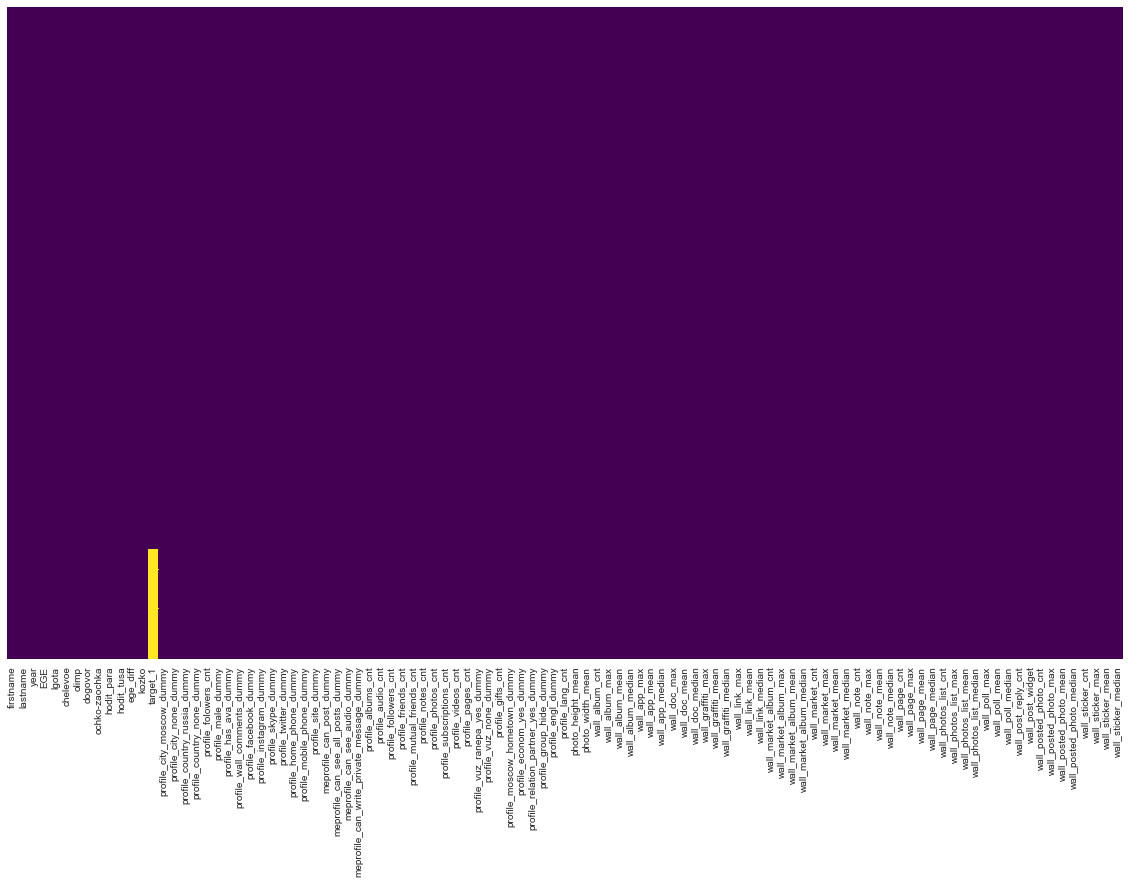

In [719]:
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Разбиваем оставшуюся табличку на тестовую и тренировочную выборки. 

In [720]:
# Убираем 2017 год 
X_2017 = data[data.year == 2017].drop(['year','target_1'],axis=1)

# Запоминаем имена для прогнозов 
names_2017 = X_2017.firstname.get_values() + X_2017.lastname.get_values()
X_2017.drop(['firstname', 'lastname'], axis=1, inplace=True)

# Выделяем 2016 год как тестовую выборку 
X_test = data[data.year == 2016].drop(['year','target_1'],axis=1)
names_2016 = X_test.firstname.get_values() + X_test.lastname.get_values()
X_test.drop(['firstname', 'lastname'], axis=1, inplace=True)
y_test = data[data.year == 2016]['target_1'].get_values()

# Выделяем остальное как тернировочную выборку
X_train = data[data.year < 2016].drop(['year','target_1'],axis=1)
X_train.drop(['firstname', 'lastname'], axis=1, inplace=True)
y_train = data[data.year < 2016]['target_1'].get_values()

# списки переменных для табличек
real_vars = [var for var in X_train.columns if var in real_set]
cnt_vars = [var for var in X_train.columns if var in cnt_set]
dummy_vars = [var for var in X_train.columns if var in dummy_set]

# Немного стандартизации для непрерывных переменных
from sklearn.preprocessing import StandardScaler  # Для непрерывных переменных 
from sklearn.preprocessing import MinMaxScaler    # Для счётчиков 
sscaler = StandardScaler()
mscaler = MinMaxScaler()

X_train[real_vars] = sscaler.fit_transform(X_train[real_vars])
X_test[real_vars] = sscaler.transform(X_test[real_vars])

X_train[cnt_vars] = mscaler.fit_transform(X_train[cnt_vars])
X_test[cnt_vars] = mscaler.transform(X_test[cnt_vars])

# Запоминаем в отдельный массив названия переменных 
varnames = X_train.columns.get_values()

# Вытаскиваем матрицы
X_train = X_train.get_values()
X_test = X_test.get_values()

print('\n Метки:', '\n', y_test[:10], '\n')
print('Переменные: \n', X_test[:2], '\n')

print('Всего:', data.shape)
print('Трэйн:', X_train.shape, y_train.shape)
print('Тест:', X_test.shape, y_test.shape)

print('Число переменных:', len(varnames))
print('действительных: ' + str(len(real_vars)),'счётчиков: ' + str(len(cnt_vars)),
      'дамми: ' + str(len(dummy_vars)),'категориальных: ' + str(len(cat_vars)), sep=', ')


 Метки: 
 [ 0.  1.  1.  1.  0.  1.  0.  0.  0.  0.] 

Переменные: 
 [[ -1.72280656e-01   0.00000000e+00   1.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   3.33936519e-01  -8.24948277e-01
   -2.41448583e-01   0.00000000e+00   1.00000000e+00   0.00000000e+00
    1.00000000e+00   0.00000000e+00   9.46593002e-02   0.00000000e+00
    1.00000000e+00   1.00000000e+00   0.00000000e+00   1.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.17647059e-01   2.61854707e-01   9.46593002e-02
    3.51354549e-02   3.16666667e-01   0.00000000e+00   2.41545894e-02
    0.00000000e+00   7.30557738e-02   7.26775956e-01   1.00000000e+00
    0.00000000e+00   2.97435897e-01   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    4.38059129e-02   2.74024634e-01   0.00000000e+00  -1.90029107e-01
   -1.15538597e-01   

# 2. Константный прогноз 

Посмотрим на константный прогноз, чтобы было с чем сранвинвать. 

In [721]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

n_train = y_train.shape[0]
n_test = y_test.shape[0]

print('Трэйн:')
print('accuracy_0 :', accuracy_score(y_train, [0]*n_train))
print('accuracy_1 :', accuracy_score(y_train, [1]*n_train))
print('roc-auc:', roc_auc_score(y_train, np.ones(y_train.shape)))

print( '\n', 'Тест:')
print('accuracy_0 :', accuracy_score(y_test, [0]*n_test))
print('accuracy_1 :', accuracy_score(y_test, [1]*n_test))
print ('roc-auc:', roc_auc_score(y_test, np.ones(y_test.shape)))

Трэйн:
accuracy_0 : 0.269784172662
accuracy_1 : 0.730215827338
roc-auc: 0.5

 Тест:
accuracy_0 : 0.285714285714
accuracy_1 : 0.714285714286
roc-auc: 0.5


Вывод: любая модель с точностью менее 70% сразу отправляется на помойку. 

# 3. Регрессия - моя профессия 

In [722]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools

# Функция для вывода метрик качества
def printer(model, y_train=y_train, y_test=y_test, X_train=X_train, X_test=X_test):
    y_hat_train = model.predict_proba(X_train)[:,1]
    y_hat_test = model.predict_proba(X_test)[:,1]
    print ('Train accuracy', accuracy_score(y_train, model.predict(X_train)))
    print ('Validation accuracy', accuracy_score(y_test, model.predict(X_test)), '\n')
    print ('Train roc-auc', roc_auc_score(y_train, y_hat_train))
    print ('Validation roc-auc', roc_auc_score(y_test, y_hat_test))
    
# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(model, y_train=y_train, y_test=y_test, X_train=X_train, X_test=X_test):
    y_hat_train = model.predict_proba(X_train)[:,1]
    y_hat_test = model.predict_proba(X_test)[:,1]
    
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_train = roc_auc_score(y_train, y_hat_train)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()
  

 # Функция для отрисовки конфьюжн матрикс 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    

Качество на кросс-валидации: 0.719611968209 

Train accuracy 0.874100719424
Validation accuracy 0.842857142857 

Train roc-auc 0.938784893268
Validation roc-auc 0.847


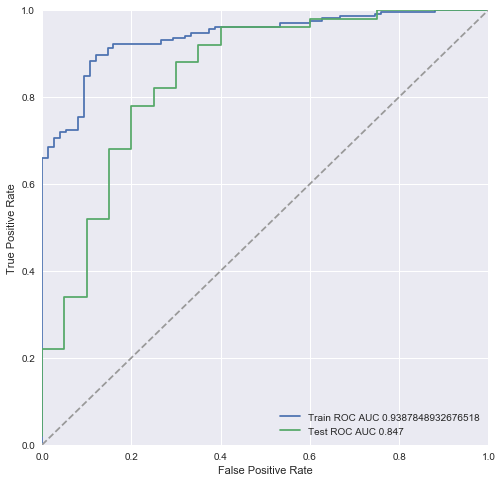

In [723]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

# Обучаем логистическую регрессию 
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(lr, X_train, y_train, scoring = 'accuracy', cv =3)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

# Качество на трэйне и тесте и картинка
printer(lr)
roc_auc_pic(lr)


Та же модель, но с перебором по решётке параметра. 

{'C': 0.4271356784834171}


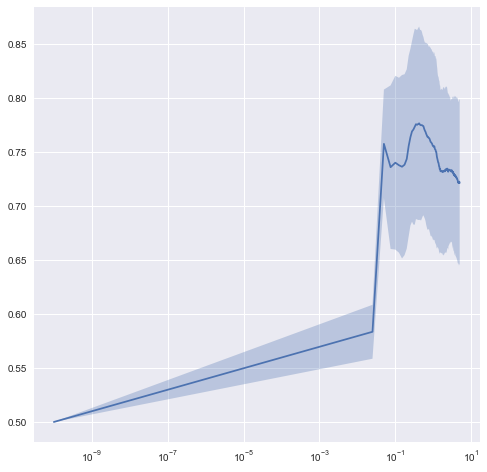

In [724]:
from sklearn.grid_search import GridSearchCV

def plot_scores(optimizer):
    print( optimizer.best_params_)
    scores = [[item[0]['C'], 
               item[1], 
               (np.sum((item[2]-item[1])**2)/(item[2].size-1))**0.5] for item in optimizer.grid_scores_]
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()
    
    

parameters_grid = {
    # 'penalty' : ['l1', 'l2'],
    'C' : np.linspace(0.0000000001, 5, num = 200)
}

gridsearch = GridSearchCV(LogisticRegression(penalty = 'l1'), parameters_grid, scoring = 'roc_auc', cv = 3)

gridsearch.fit(X_train, y_train)
plot_scores(gridsearch)

Качество на кросс-валидации: 0.712638304504 

Число переменных: 24
Train accuracy 0.841726618705
Validation accuracy 0.814285714286 

Train roc-auc 0.911921182266
Validation roc-auc 0.83


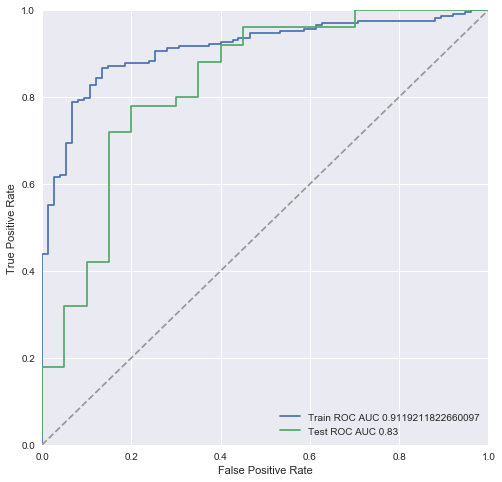

In [730]:
# Обучаем логистическую регрессию 
lr = LogisticRegression(penalty='l1', C = 0.42, class_weight='balanced')
lr.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(lr, X_train, y_train, scoring = 'accuracy', cv =3)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

print('Число переменных:', len([var for var in lr.coef_[0] if abs(var) > 0]))

# Качество на трэйне и тесте и картинка
printer(lr)
roc_auc_pic(lr)

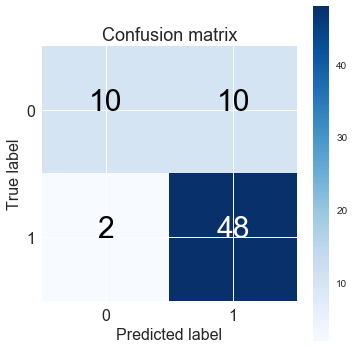

In [731]:
cm = confusion_matrix(y_test, y_pred_test_classes)
plot_confusion_matrix(cm, classes=['0', '1'])

In [732]:
report = classification_report(y_test, lr.predict(X_test))
print(report)

             precision    recall  f1-score   support

        0.0       0.71      0.60      0.65        20
        1.0       0.85      0.90      0.87        50

avg / total       0.81      0.81      0.81        70



In [733]:
name_pred = [(a,b[0],b[1]) for a, b in zip(names_2016, zip(lr.predict_proba(X_test_sub)[:,-1],y_test))]
sorted(name_pred, key=lambda w: w[1], reverse=True)

[('КуркинНиколай', 0.99716291631598719, 1.0),
 ('СемёноваАлёна', 0.98686088195414312, 1.0),
 ('ДаминоваРита', 0.97162150513300016, 1.0),
 ('ПетайкинаАнастасия', 0.97002406159277399, 1.0),
 ('ЛушинаВалерия', 0.95870666086165401, 1.0),
 ('АхмедоваВазифа', 0.95839439944272042, 1.0),
 ('МорозоваВиолетта', 0.95740542261054762, 1.0),
 ('КириленкоСветлана', 0.9557186269033211, 1.0),
 ('ГвоздеваЕлизавета', 0.95271816812626742, 1.0),
 ('СкибенкоСветлана', 0.95111396053270192, 0.0),
 ('КоролькевичГлеб', 0.93694180171442898, 1.0),
 ('СаковичДарья', 0.93579718831001046, 1.0),
 ('ГаджиеваАида', 0.93276738861518771, 1.0),
 ('ЛомоносовДаниил', 0.931031047415665, 1.0),
 ('КусегеновДанислам', 0.92354766406101074, 1.0),
 ('СамойловаКатя', 0.91532580219061399, 1.0),
 ('ПотаповаМария', 0.91257125501353853, 1.0),
 ('ВагановаДаша', 0.91238820472203341, 0.0),
 ('АксеноваАнна', 0.91115455183539973, 1.0),
 ('ЕфремоваОльга', 0.90424701408537067, 1.0),
 ('АскольскаяНадежда', 0.90223468672294471, 1.0),
 ('Радионо

# 4. Отбор регрессоров 

## 4.1 Отбор переменных с помощью Lasso 

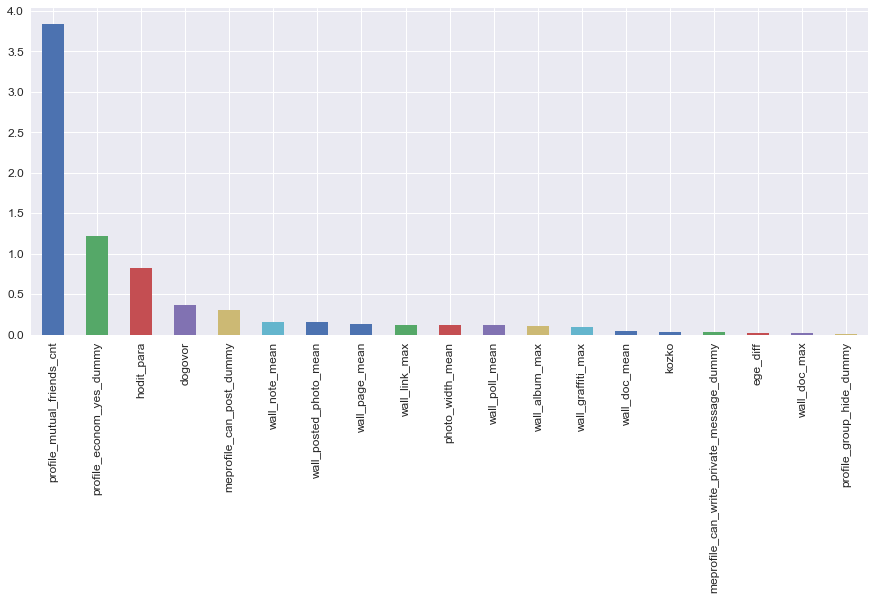

In [662]:
imps = pd.Series([abs(cf) for cf in lr.coef_[0]],index=varnames)

lasso_features = np.array(imps[imps > 0].index)

imps = imps.sort_values(ascending=False)[:len(lasso_features)]
imps.plot(kind='bar', figsize=(15,6), fontsize=12)

# Оставляем только незанулившиеся переменные 
ind_lasso = np.array([np.where(varnames == ft)[0][0] for ft in lasso_features])

## 4.2 Отбор переменных на основе леса 

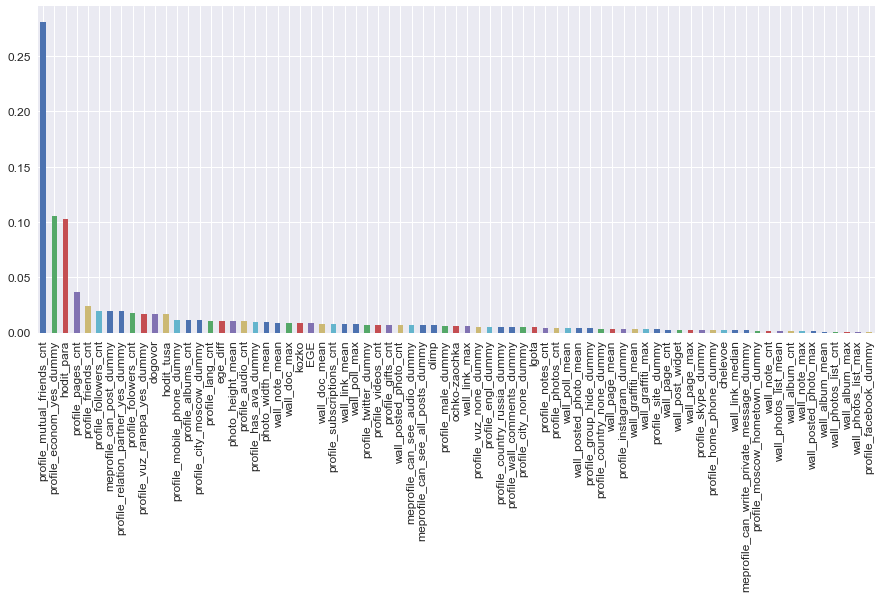

In [663]:
from sklearn.ensemble import ExtraTreesRegressor
selection_tree = ExtraTreesRegressor(n_estimators=100,random_state=42)
selection_tree.fit(X_train,y_train)

imps = pd.Series([cf for cf in selection_tree.feature_importances_],index=varnames)

# Оставляем только незанулившиеся переменные 
tree_features = np.array(imps[imps > 0].index)
ind_tree = np.array([np.where(varnames == ft)[0][0] for ft in tree_features])

imps = imps.sort_values(ascending=False)[:len(tree_features)]
imps.plot(kind='bar', figsize=(15,6), fontsize=12)

# 5. Логрегрессия по подвыборке

# 6. Простенькая нейросеточка

In [684]:
X_train_sub = X_train#[:,ind_lasso]
X_test_sub = X_test#[:,ind_lasso]

# X_train_sub = X_train[:,ind_tree]
# X_test_sub = X_test[:,ind_tree]

In [685]:
import keras
from keras.models import Sequential   # Последовательность слоёв
import keras.layers as L              # Разные слои
import keras.optimizers as opt        # Оптимизаторы
from keras.utils.np_utils import to_categorical  # Для преобразования y в категориальный формат 

In [686]:
def get_new_model(order):
    # Задаём модель и называем её Ахмед
    model = Sequential(name = 'Julia')

    # Добавляем в нашу модель первый слой из 20 нейронов
    # На вход в эти 25 нейронов будут индти все наши регрессоры
    model.add(L.Dense(8, input_dim = order, kernel_initializer='random_normal'))
    
    model.add(L.Dropout(0.5))
    # Добавляем функцию активации на первый слой 
    model.add(L.Activation('relu'))

    # Добавляем ещё один слой из 25 нейронов
    model.add(L.Dense(8, kernel_initializer='random_normal'))
    model.add(L.Dropout(0.5))
    model.add(L.Activation('relu'))

    # На выходе мы должны получить вероятности того, что объект относится к разным классам 
    # Сделать такое преобразование позволяет softmax как функция активации
    # На выход будет идти 2 вероятности по числу классов
    model.add(L.Dense(2, activation='softmax', kernel_initializer = 'random_normal'))

    # В качестве оптимизации будем использовать Adam
    optimizer = opt.Adam(lr=1e-3)

    # Собираем модельa
    model.compile(loss = 'categorical_crossentropy', metrics=["accuracy"], optimizer=optimizer)
    return model

In [687]:
np.random.seed(42)
model = get_new_model(X_train_sub.shape[1])

In [688]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_112 (Dense)            (None, 8)                 800       
_________________________________________________________________
dropout_67 (Dropout)         (None, 8)                 0         
_________________________________________________________________
activation_75 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_113 (Dense)            (None, 8)                 72        
_________________________________________________________________
dropout_68 (Dropout)         (None, 8)                 0         
_________________________________________________________________
activation_76 (Activation)   (None, 8)                 0         
_________________________________________________________________
dense_114 (Dense)            (None, 2)                 18        
Total para

In [689]:
np.random.seed(42)
hist = model.fit(X_train_sub, to_categorical(y_train), validation_split=0.2, epochs=140,
                   verbose=0)

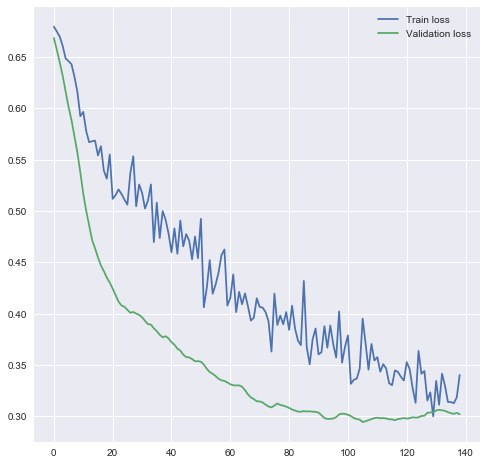

In [690]:
start = 1
plt.plot(hist.history['loss'][start:])
plt.plot(hist.history['val_loss'][start:])
plt.legend(['Train loss', 'Validation loss'])

In [691]:
# Можно предсказать вероятности для тестовой выборки
model.predict_proba(X_test_sub)[:,-1]

array([ 0.53235948,  0.9777655 ,  0.42918274,  0.99998534,  0.39352387,
        0.91922861,  0.98710454,  0.32200867,  0.32664624,  0.9781003 ,
        0.87924457,  0.99969268,  0.99839514,  0.94088006,  0.99021727,
        0.99930489,  0.99669802,  0.99999917,  0.99991667,  0.99436635,
        0.99992561,  0.99413931,  0.99818462,  0.98302078,  0.99777299,
        0.95293289,  0.99983037,  0.96816909,  0.82704514,  0.99529856,
        0.9968071 ,  0.99950838,  0.99646384,  0.99866593,  0.99920219,
        0.43603218,  0.29271317,  0.9939183 ,  0.99985993,  0.98241389,
        0.90584552,  0.99132442,  0.99658871,  0.8445968 ,  0.96406662,
        0.74009007,  0.67801136,  0.32256928,  0.99893492,  0.97745413,
        0.99237978,  0.2849744 ,  0.99287593,  0.99426657,  0.92209065,
        0.99990618,  0.70483619,  0.998555  ,  0.58417559,  0.99118412,
        0.99849749,  0.81045693,  0.51641059,  0.99198991,  0.79297483,
        0.31339419,  0.26575494,  0.31701043,  0.32986352,  0.53

In [692]:
# А можно классы 
model.predict_classes(X_test_sub)

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1])

Train accuracy 0.913669064748
Validation accuracy 0.828571428571 

Train roc-auc 0.95829228243
Validation roc-auc 0.832


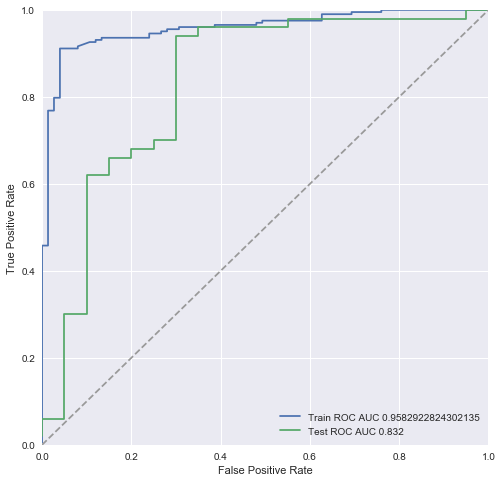

In [697]:
y_tr_hat_nn = model.predict_classes(X_train_sub)
y_ts_hat_nn = model.predict_classes(X_test_sub)

y_hat_train = model.predict_proba(X_train_sub)[:,-1]
y_hat_test = model.predict_proba(X_test_sub)[:,-1]

print ('Train accuracy', accuracy_score(y_train, y_tr_hat_nn))
print ('Validation accuracy', accuracy_score(y_test, y_ts_hat_nn), '\n')
print ('Train roc-auc', roc_auc_score(y_train, y_hat_train))
print ('Validation roc-auc', roc_auc_score(y_test, y_hat_test))


fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_hat_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
roc_auc_train = roc_auc_score(y_train, y_hat_train)
roc_auc_test = roc_auc_score(y_test, y_hat_test)

matplotlib.rcParams['figure.figsize'] = (8, 8)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

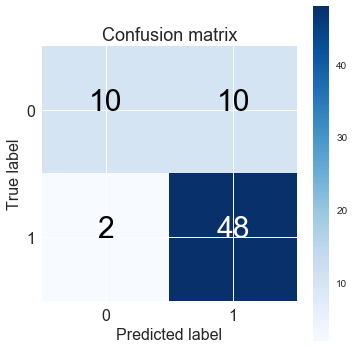

In [698]:
cm = confusion_matrix(y_test, y_ts_hat_nn)
plot_confusion_matrix(cm, classes=['0', '1'])

In [699]:
report = classification_report(y_test, lr.predict(X_test))
print(report)

             precision    recall  f1-score   support

        0.0       0.82      0.45      0.58        20
        1.0       0.81      0.96      0.88        50

avg / total       0.81      0.81      0.79        70



             precision    recall  f1-score   support

        0.0       0.72      0.83      0.77        75
        1.0       0.93      0.88      0.91       203

avg / total       0.88      0.87      0.87       278

0.86690647482


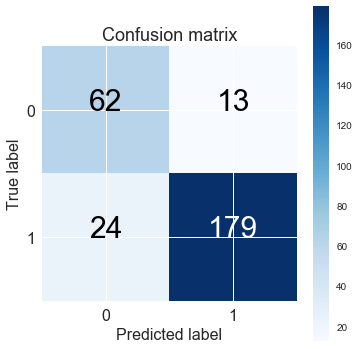

In [700]:
# Отсекаем порог по ROC_AUC 
yhtr = 1*(lr.predict_proba(X_train)[:,-1] > 0.6)

report = classification_report(y_train, yhtr)
print(report)

print(accuracy_score(y_train, yhtr))

cm = confusion_matrix(y_train, yhtr)
plot_confusion_matrix(cm, classes=['0', '1'])

             precision    recall  f1-score   support

        0.0       0.75      0.60      0.67        20
        1.0       0.85      0.92      0.88        50

avg / total       0.82      0.83      0.82        70

0.828571428571


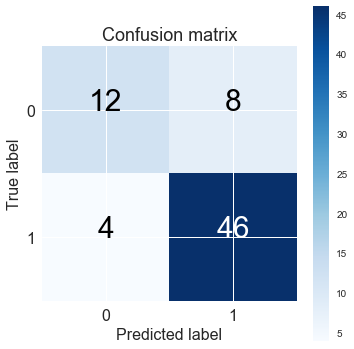

In [701]:
# Отсекаем порог по ROC_AUC 
yhtr = 1*(lr.predict_proba(X_test)[:,-1] > 0.6)

report = classification_report(y_test, yhtr)
print(report)

print(accuracy_score(y_test, yhtr))

cm = confusion_matrix(y_test, yhtr)
plot_confusion_matrix(cm, classes=['0', '1'])

In [702]:
name_pred = [(a,b[0],b[1]) for a, b in zip(names_2016, zip(model.predict_proba(X_test_sub)[:,-1],y_test))]
sorted(name_pred, key=lambda w: w[1], reverse=True)

[('СемёноваАлёна', 0.99999917, 1.0),
 ('КуркинНиколай', 0.99998534, 1.0),
 ('МорозоваВиолетта', 0.99992561, 1.0),
 ('СкибенкоСветлана', 0.99991667, 0.0),
 ('ГвоздеваЕлизавета', 0.99990618, 1.0),
 ('КириленкоСветлана', 0.99985993, 1.0),
 ('ДаминоваРита', 0.99983037, 1.0),
 ('СамойловаКатя', 0.99969268, 1.0),
 ('ЛушинаВалерия', 0.99950838, 1.0),
 ('ПетайкинаАнастасия', 0.99930489, 1.0),
 ('ЖуковскаяОксана', 0.99920219, 1.0),
 ('СаковичДарья', 0.99893492, 1.0),
 ('КусегеновДанислам', 0.99866593, 1.0),
 ('АксеноваАнна', 0.998555, 1.0),
 ('ЧелядиноваЕкатерина', 0.99849749, 1.0),
 ('РадионоваЕлена', 0.99839514, 1.0),
 ('ВагановаДаша', 0.99818462, 0.0),
 ('ГоворковаДарья', 0.99777299, 1.0),
 ('ЗайцеваАнна', 0.9968071, 1.0),
 ('ДугароваАлександра', 0.99669802, 1.0),
 ('КоролькевичГлеб', 0.99658871, 1.0),
 ('СидоровАлександр', 0.99646384, 1.0),
 ('ЕфремоваОльга', 0.99529856, 1.0),
 ('ХаритоноваМарина', 0.99436635, 1.0),
 ('ДобрынинаЕкатерина', 0.99426657, 1.0),
 ('ПотаповаМария', 0.99413931, 1.

# 7. Деревья 

Качество на кросс-валидации: 0.777076515506 

Train accuracy 0.996402877698
Validation accuracy 0.771428571429 

Train roc-auc 0.999901477833
Validation roc-auc 0.781


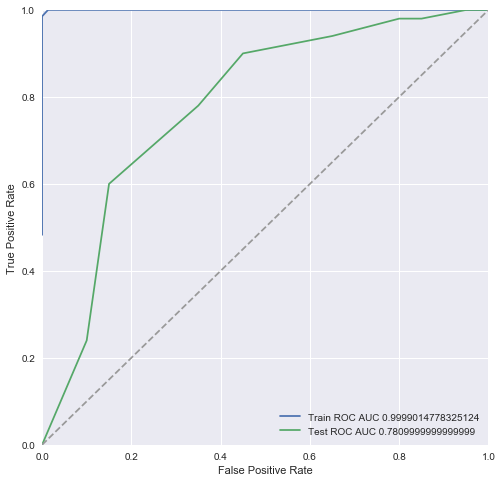

In [341]:
np.random.seed(42)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10,max_features='sqrt',random_state=42)
rf.fit(X_train, y_train)

# Качество модели на кросс-валидации 
scoring = cross_val_score(rf, X_train, y_train, scoring = 'accuracy', cv =3)
print('Качество на кросс-валидации:', scoring.mean(), '\n')

printer(rf)
roc_auc_pic(rf)

# 8.  Xgboost

In [382]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

gbm = xgb.XGBClassifier( )

gbm_param_grid = {
    "colsample_bytree" : np.linspace(0.2,1,num=10),
    "subsample" : np.linspace(0.2,1,num=10),
    "n_estimators" : range(10,50),
    "max_depth" : range(2,12),
    "learning_rate": np.linspace(0,0.2,num=10),
    "gamma": np.linspace(0,10,num=21),
    #'reg_alpha': np.linspace(0,50,num=21),
    "min_child_weight": np.linspace(0,20,num=21)
}

# Если выборка большая, ставить 1000 итераций - плохая идея, так как будет обучаться 4000 моделей
randomized_mse = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid, 
                                    scoring="accuracy", cv=4, verbose=1,n_iter=1000)

randomized_mse.fit(X_train,y_train)

print("Лучшие параметры: ", randomized_mse.best_params_)
print('\n')
print("Самый крутой accuracy: ", randomized_mse.best_score_)

printer(randomized_mse)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits
Лучшие параметры:  {'subsample': 0.64444444444444449, 'n_estimators': 13, 'min_child_weight': 1.0, 'max_depth': 2, 'learning_rate': 0.20000000000000001, 'gamma': 0.0, 'colsample_bytree': 0.37777777777777777}


Самый крутой accuracy:  0.870503597122
Train accuracy 0.884892086331
Validation accuracy 0.771428571429 

Train roc-auc 0.953957307061
Validation roc-auc 0.733


[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:  2.0min finished


# 6. Ансамбль 

In [734]:
a = 'tab_num|year_month|Date_nachala_raboty|Date_nachala_raboty_erkc|year_quarter|Work_erkc_3m|Work_erkc_6m|Work_erkc_12m|vk_has_photo|vk_has_mobile|vk_cnt_albums|vk_cnt_audios|vk_cnt_followers|vk_cnt_gifts|vk_cnt_groups|vk_cnt_notes|vk_cnt_pages|vk_cnt_photos|vk_cnt_subscriptions|vk_cnt_user_photos|vk_cnt_videos|vk_cnt_friends|vk_share_friends_sberbank|vk_share_friends_women|vk_share_friends_men|vk_interest_topic_0|vk_interest_topic_1|vk_interest_topic_2|vk_interest_topic_3|vk_interest_topic_4|vk_interest_topic_5|vk_interest_topic_6|vk_interest_topic_7|vk_interest_topic_8|vk_interest_topic_9|vk_interest_topic_10|vk_interest_topic_11|vk_interest_topic_12|vk_interest_topic_13|vk_interest_topic_14|vk_interest_topic_15|vk_interest_topic_16|vk_interest_topic_17|vk_interest_topic_18|vk_interest_topic_19|Solution_Data|HTline_general|HTline_verbal|HTline_erudit|HTline_numeric|HTline_info|HTline_int_ext|HTline_independence|HTline_selfcontrol|HTline_anxiety|HTline_conservatism|HTline_quiet|HTline_active|HTline_simple|HTline_complex|HTline_min_communucation|HTline_max_communication|HTline_single|HTline_team|HTline_subordite|HTline_domint|HTline_reglamented|HTline_free|HTline_constant|HTline_project|HTline_quiet_active|HTline_easy_complex|HTline_min_max_communication|HTline_single_team|HTline_subord_domint|HTline_regl_free|HTline_const_project|HTline__lider|HTline__team|HTline__client|HTline_system|HTline_comm_infl|HTline_mp|HTline_int_ext_profile|HTline_indep_sogl_profile|HTline_info_process_profile|Lang_cnt_top3_lev3|Lang_cnt_top3_lev2|Lang_me_lev|Lang_cnt_all|Lang_flag|Lang_cnt_all_lev2|Lang_asia_lev|Lang_other_flag|Lang_ee_flag|Lang_cnt_all_lev1|Lang_cnt_top3|Lang_ca_flag|Lang_cnt_all_lev3|Lang_asia_flag|Lang_ee_lev|Lang_cnt_top3_lev1|Lang_we_flag|Lang_other_lev|Lang_Caucasus_flag|Lang_eng_lev|Lang_ca_lev|Lang_we_lev|Lang_me_flag|Lang_Caucasus_lev|vk_photo_ava_change_cnt|vk_photo_cnt|vk_photo_like_cnt|vk_photo_like_max|vk_photo_like_mean|vk_photo_like_median|vk_photo_repost_cnt|vk_photo_repost_max|vk_photo_repost_mean|vk_photo_repost_median|vk_photo_text_len_cnt|vk_photo_text_len_max|vk_photo_text_len_mean|vk_photo_text_len_median|vk_photo_text_url_len_cnt|vk_photo_wall_ph_post_cnt|vk_wall_album_cnt|vk_wall_album_max|vk_wall_album_mean|vk_wall_album_median|vk_wall_app_cnt|vk_wall_app_max|vk_wall_app_mean|vk_wall_app_median|vk_wall_audio_cnt|vk_wall_audio_max|vk_wall_audio_mean|vk_wall_audio_median|vk_wall_can_comment|vk_wall_comment_cnt|vk_wall_comment_max|vk_wall_comment_mean|vk_wall_comment_median|vk_wall_doc_cnt|vk_wall_doc_max|vk_wall_doc_mean|vk_wall_doc_median|vk_wall_emoji_cnt|vk_wall_emoji_max|vk_wall_emoji_mean|vk_wall_emoji_median|vk_wall_graffiti_cnt|vk_wall_graffiti_max|vk_wall_graffiti_mean|vk_wall_graffiti_median|vk_wall_lag_minute_mean|vk_wall_lag_minute_median|vk_wall_like_cnt|vk_wall_like_max|vk_wall_like_mean|vk_wall_like_median|vk_wall_link_cnt|vk_wall_link_max|vk_wall_link_mean|vk_wall_link_median|vk_wall_market_album_cnt|vk_wall_market_album_max|vk_wall_market_album_mean|vk_wall_market_album_median|vk_wall_market_cnt|vk_wall_market_max|vk_wall_market_mean|vk_wall_market_median|vk_wall_note_cnt|vk_wall_note_max|vk_wall_note_mean|vk_wall_note_median|vk_wall_page_cnt|vk_wall_page_max|vk_wall_page_mean|vk_wall_page_median|vk_wall_photo_cnt|vk_wall_photo_max|vk_wall_photo_mean|vk_wall_photo_median|vk_wall_photos_list_cnt|vk_wall_photos_list_max|vk_wall_photos_list_mean|vk_wall_photos_list_median|vk_wall_poll_cnt|vk_wall_poll_max|vk_wall_poll_mean|vk_wall_poll_median|vk_wall_post_android_cnt|vk_wall_post_cnt|vk_wall_post_instagram_cnt|vk_wall_post_ipad_cnt|vk_wall_post_iphone_cnt|vk_wall_post_len_cnt|vk_wall_post_len_max|vk_wall_post_len_mean|vk_wall_post_len_median|vk_wall_post_mob_cnt|vk_wall_post_original_cnt|vk_wall_post_other_cnt|vk_wall_post_reply_cnt|vk_wall_post_web_cnt|vk_wall_post_widget_cnt|vk_wall_post_wphone_cnt|vk_wall_posted_photo_cnt|vk_wall_posted_photo_max|vk_wall_posted_photo_mean|vk_wall_posted_photo_median|vk_wall_repost_cnt|vk_wall_repost_group_cnt|vk_wall_repost_max|vk_wall_repost_mean|vk_wall_repost_median|vk_wall_repost_user_cnt|vk_wall_sticker_cnt|vk_wall_sticker_max|vk_wall_sticker_mean|vk_wall_sticker_median|vk_wall_video_cnt|vk_wall_video_max|vk_wall_video_mean|vk_wall_video_median|sd_russian_citizen_nflag|sd_resident_nflag|crd_tot_act_qty|crd_dc_act_nflag|crd_cc_act_nflag|crd_act_to_tot_pct|crd_otf_cc_to_dc_rub_pct|prd_mb_active_nflag|prd_ib_active_nflag|cred_tot_os_to_inf_rub_pct|cred_tot_os_to_in_rub_pct|tot_os_to_inf_prcntl_pct|tot_os_to_in_prcntl_pct|cred_pl_os_to_inf_rub_pct|cred_pl_os_to_in_rub_pct|pl_os_to_inf_prcntl_pct|pl_os_to_in_prcntl_pct|cred_tot_pmt_to_inf_rub_amt|cred_tot_pmt_to_in_rub_amt|tot_pmt_to_inf_prcntl_pct|tot_pmt_to_in_prcntl_pct|crd_cc_overdue_nflag|lne_tot_dq_entr_ever_qty|prd_mg_active_nflag|prd_pl_active_nflag|crd_cc_utilization_pct|prd_da_active_nflag|prd_sc_active_nflag|prd_ap_total_active_nv|crd_otf_cc_cash_rub_nflag|crd_pos_eat_to_in_rub_pct|crd_pos_eat_to_spend_rub_pct|eat_to_in_prcntl_pct|eat_to_spend_prcntl_pct|crd_pos_leis_to_in_rub_pct|crd_pos_leis_to_spend_rub_pct|leis_to_in_prcntl_pct|leis_to_spend_prcntl_pct|crd_pos_tour_to_in_rub_pct|crd_pos_tour_to_spend_rub_pct|tour_to_in_prcntl_pct|tour_to_spend_prcntl_pct|crd_pos_bty_to_in_rub_pct|crd_pos_bty_to_spend_rub_pct|bty_to_in_prcntl_pct|bty_to_spend_prcntl_pct|crd_pos_med_to_in_rub_pct|crd_pos_med_to_spend_rub_pct|med_to_in_prcntl_pct|med_to_spend_prcntl_pct|crd_pos_healthcare_rub_pctll|crd_pos_healthcare_qty|crd_pos_eat_out_qty|crd_pos_eat_out_rub_pctl|crd_pos_leisure_qty|crd_pos_leisure_rub_pctl|crd_pos_tourism_qty|crd_pos_tourism_rub_pctl|crd_pos_beuaty_qty|crd_pos_beuaty_rub_pctl|crd_pos_healthcare_rub_pctl|geo_drive_optimistic_dur|geo_drive_pessimistic_dur|geo_drive_best_dur|geo_drive_dur|geo_drive_dist|geo_trans_dur|geo_trans_dist|geo_walk_dur|geo_walk_dist|cnt_vuz|has_sr_spec_obraz|years_after_vuz|is_student|years_in_vuz|uch_stepen|uch_stepen_binar|vuz_economic|vuz_economic_binar|vuz_human|vuz_human_binar|vuz_natural|vuz_natural_binar|vuz_tech|vuz_tech_binar|vuz_digital|vuz_digital_binar|vuz_other|vuz_other_binar|vuz_no_data|vuz_class_count|CSI_3m|CSI_6m|CSI_12m|Gend|Gend_id|Age|age_when_start_in_sber_nv|age_when_start_in_erkc|children|Date_of_Birth|Generation|Generation_num|zodiac_name|zodiac_num|season_name|season_num|cnt_vuz_interval|vuz_graduate'

In [736]:
for var in a.split('|'):
    print(var)

tab_num
year_month
Date_nachala_raboty
Date_nachala_raboty_erkc
year_quarter
Work_erkc_3m
Work_erkc_6m
Work_erkc_12m
vk_has_photo
vk_has_mobile
vk_cnt_albums
vk_cnt_audios
vk_cnt_followers
vk_cnt_gifts
vk_cnt_groups
vk_cnt_notes
vk_cnt_pages
vk_cnt_photos
vk_cnt_subscriptions
vk_cnt_user_photos
vk_cnt_videos
vk_cnt_friends
vk_share_friends_sberbank
vk_share_friends_women
vk_share_friends_men
vk_interest_topic_0
vk_interest_topic_1
vk_interest_topic_2
vk_interest_topic_3
vk_interest_topic_4
vk_interest_topic_5
vk_interest_topic_6
vk_interest_topic_7
vk_interest_topic_8
vk_interest_topic_9
vk_interest_topic_10
vk_interest_topic_11
vk_interest_topic_12
vk_interest_topic_13
vk_interest_topic_14
vk_interest_topic_15
vk_interest_topic_16
vk_interest_topic_17
vk_interest_topic_18
vk_interest_topic_19
Solution_Data
HTline_general
HTline_verbal
HTline_erudit
HTline_numeric
HTline_info
HTline_int_ext
HTline_independence
HTline_selfcontrol
HTline_anxiety
HTline_conservatism
HTline_quiet
HTline_ac

<img align="center" src="http://img0.reactor.cc/pics/post/ванга-мемгенератор-59018.jpeg" width="300">
